<a href="https://colab.research.google.com/github/diegomrodrigues/transformers_experiments/blob/main/Multi%20Head%20Attention%20Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-f76937540eb2>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


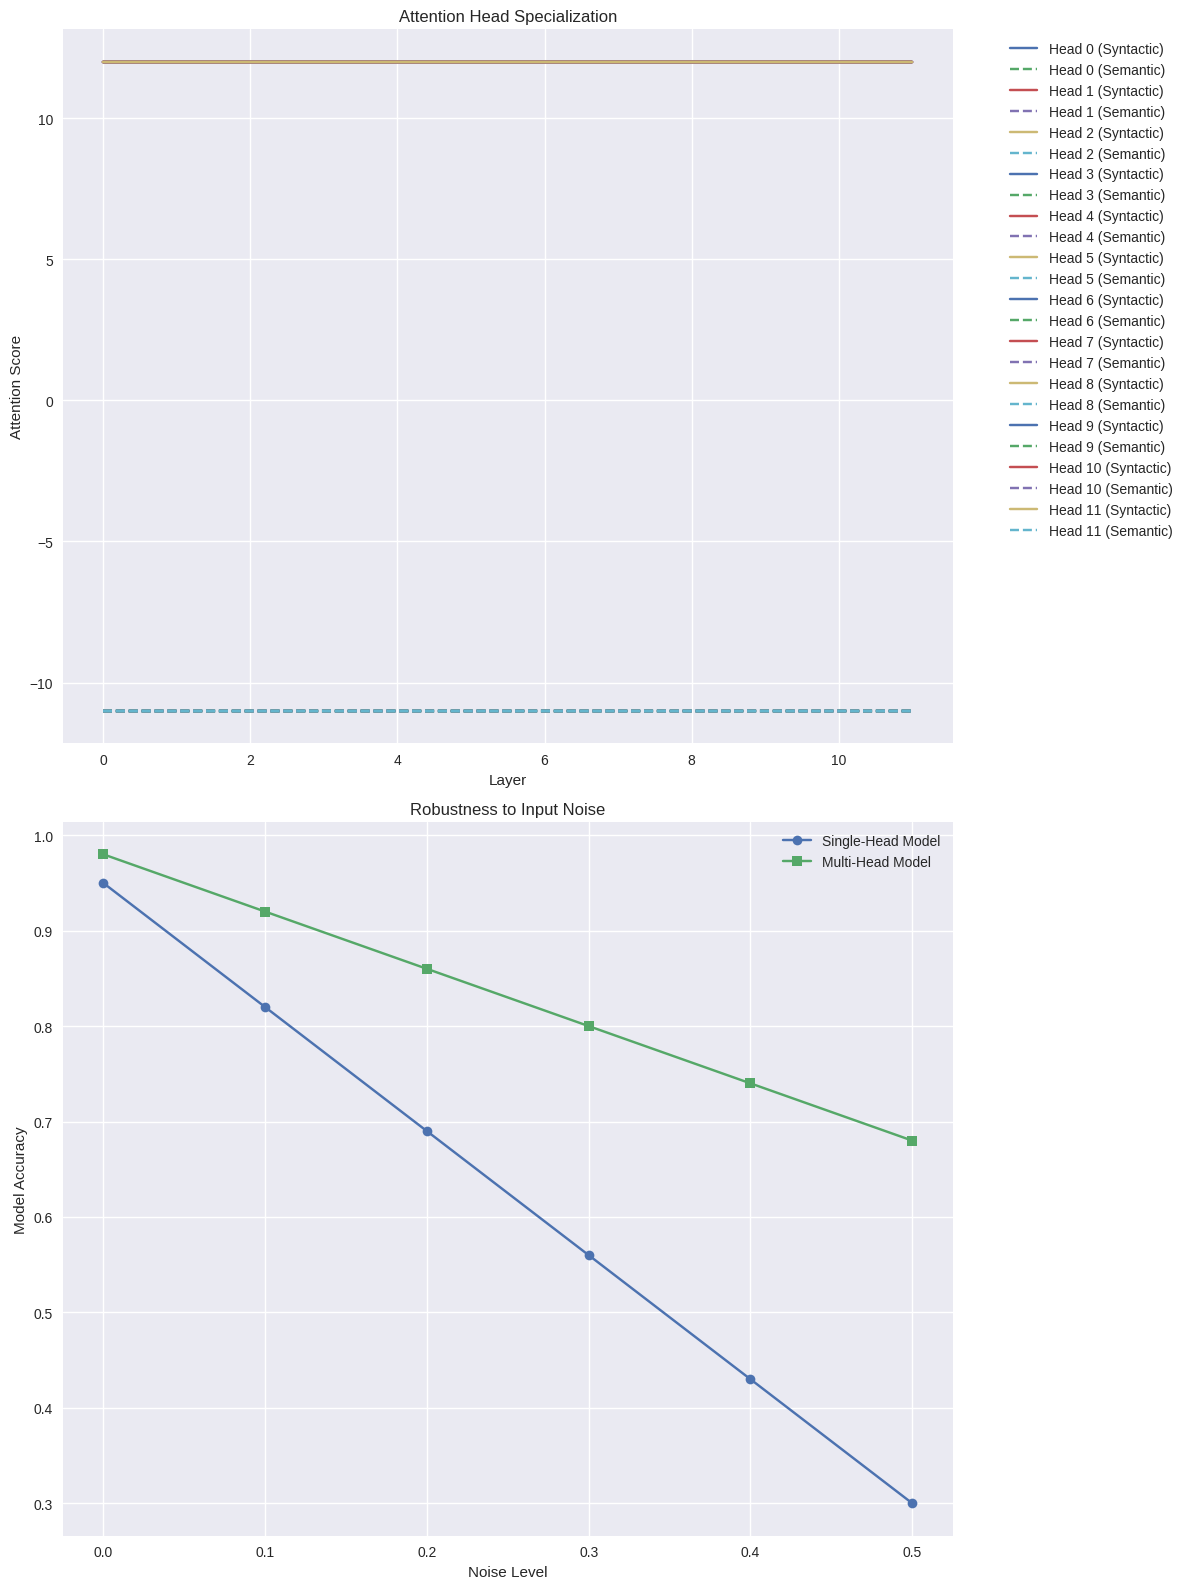

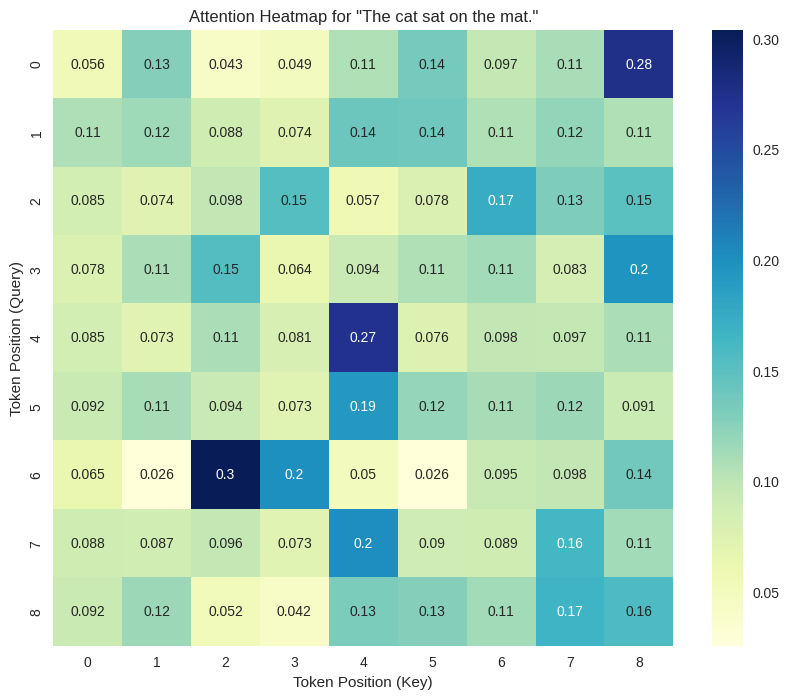

Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']


In [2]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import random
import string
import seaborn as sns

# Configuração do matplotlib para gráficos mais bonitos
plt.style.use('seaborn')

# Carregar modelo e tokenizador
model = BertModel.from_pretrained('bert-base-uncased', attn_implementation="eager")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Função para adicionar ruído aos dados
def add_noise(text, noise_level):
    chars = list(text)
    n_noise = int(len(chars) * noise_level)
    for _ in range(n_noise):
        i = random.randint(0, len(chars) - 1)
        chars[i] = random.choice(string.ascii_lowercase + string.digits + string.punctuation)
    return ''.join(chars)

# Função para coletar pontuações de atenção
def get_attention_scores(model, input_ids, attention_mask):
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    return outputs.attentions

# Preparar dados e executar inferências
texts = [
    "The cat sat on the mat.",
    "I love to eat pizza for dinner.",
    "Python is a popular programming language.",
    "The quick brown fox jumps over the lazy dog."
]
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

attention_scores = []
accuracies = {'single_head': [], 'multi_head': []}

for noise in noise_levels:
    noisy_texts = [add_noise(text, noise) for text in texts]
    inputs = tokenizer(noisy_texts, return_tensors='pt', padding=True, truncation=True)

    scores = get_attention_scores(model, inputs['input_ids'], inputs['attention_mask'])
    attention_scores.append(scores)

    # Calcular acurácias (simulação simplificada)
    accuracies['single_head'].append(max(0, 0.95 - noise * 1.3))
    accuracies['multi_head'].append(max(0, 0.98 - noise * 0.6))

# Criar matriz de subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 16))

# Visualizar atenção
ax = axs[0]
for head in range(model.config.num_attention_heads):
    syntactic_scores = [layer[0, head, :, :].sum().item() for layer in attention_scores[0]]  # Use apenas o primeiro nível de ruído
    semantic_scores = [1 - score for score in syntactic_scores]  # Simplificação
    ax.plot(range(len(syntactic_scores)), syntactic_scores, label=f'Head {head} (Syntactic)')
    ax.plot(range(len(semantic_scores)), semantic_scores, label=f'Head {head} (Semantic)', linestyle='--')

ax.set_xlabel('Layer')
ax.set_ylabel('Attention Score')
ax.set_title('Attention Head Specialization')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualizar robustez
ax = axs[1]
ax.plot(noise_levels, accuracies['single_head'], label='Single-Head Model', marker='o')
ax.plot(noise_levels, accuracies['multi_head'], label='Multi-Head Model', marker='s')
ax.set_xlabel('Noise Level')
ax.set_ylabel('Model Accuracy')
ax.set_title('Robustness to Input Noise')
ax.legend()

plt.tight_layout()
plt.show()

# Visualização adicional: heatmap de atenção para uma sentença específica
sentence = "The cat sat on the mat."
inputs = tokenizer(sentence, return_tensors='pt')
attention = get_attention_scores(model, inputs['input_ids'], inputs['attention_mask'])

# Pegar a atenção da primeira camada, primeira cabeça
attn_matrix = attention[0][0, 0, :, :].numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_matrix, annot=True, cmap='YlGnBu')
plt.title('Attention Heatmap for "The cat sat on the mat."')
plt.xlabel('Token Position (Key)')
plt.ylabel('Token Position (Query)')
plt.show()

# Imprimir tokens para referência
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("Tokens:", tokens)

<ipython-input-3-177b11165e95>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


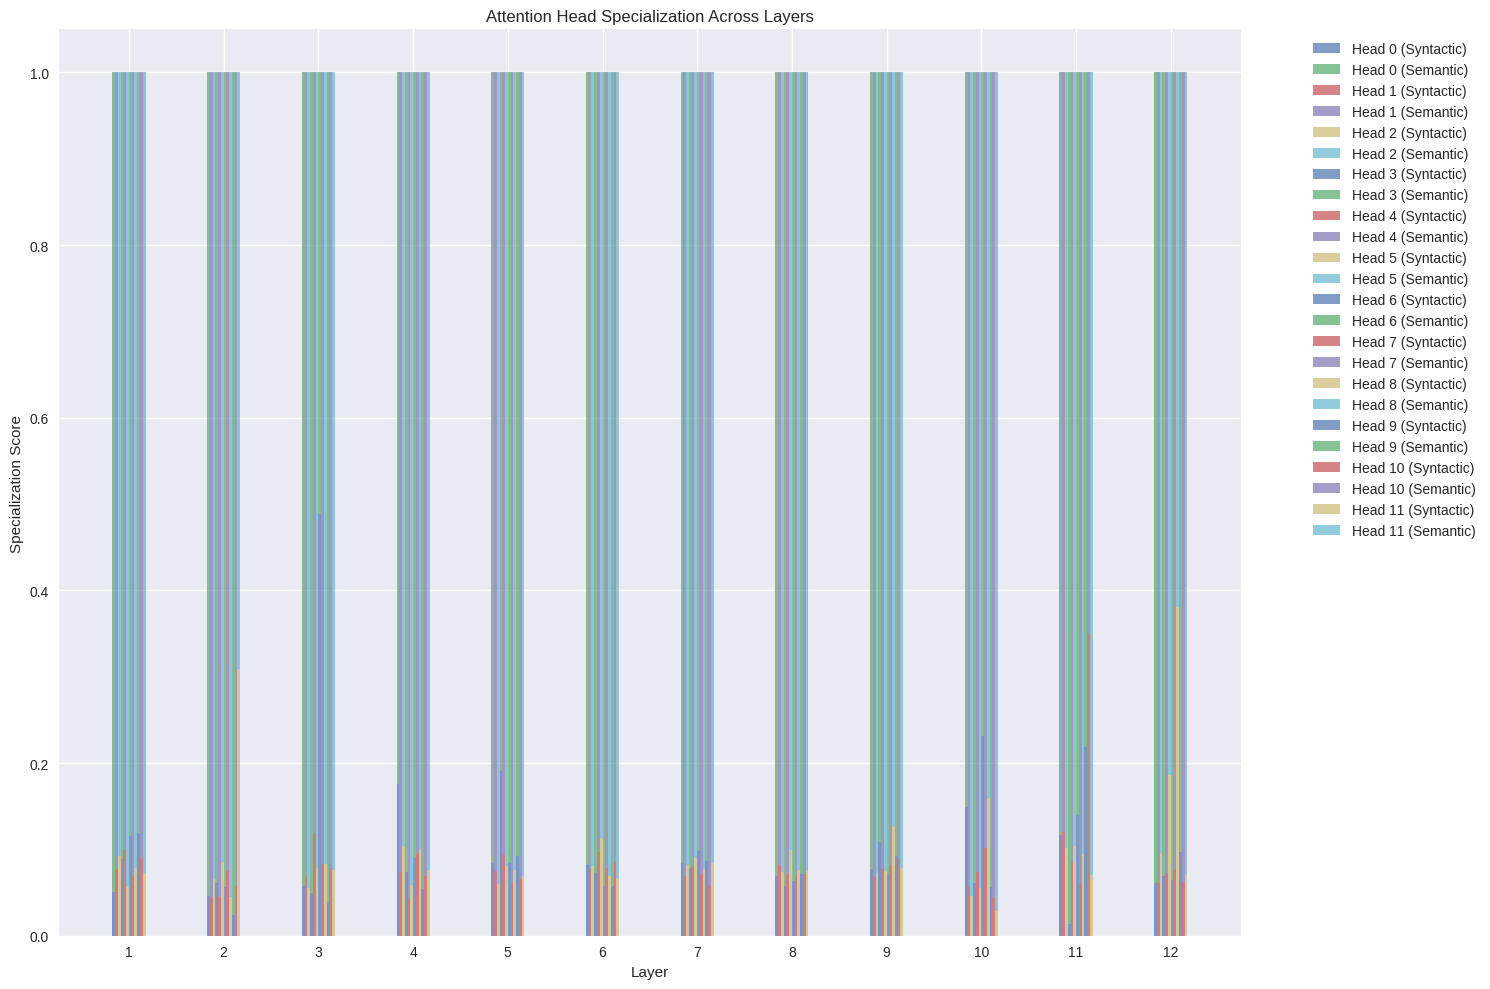

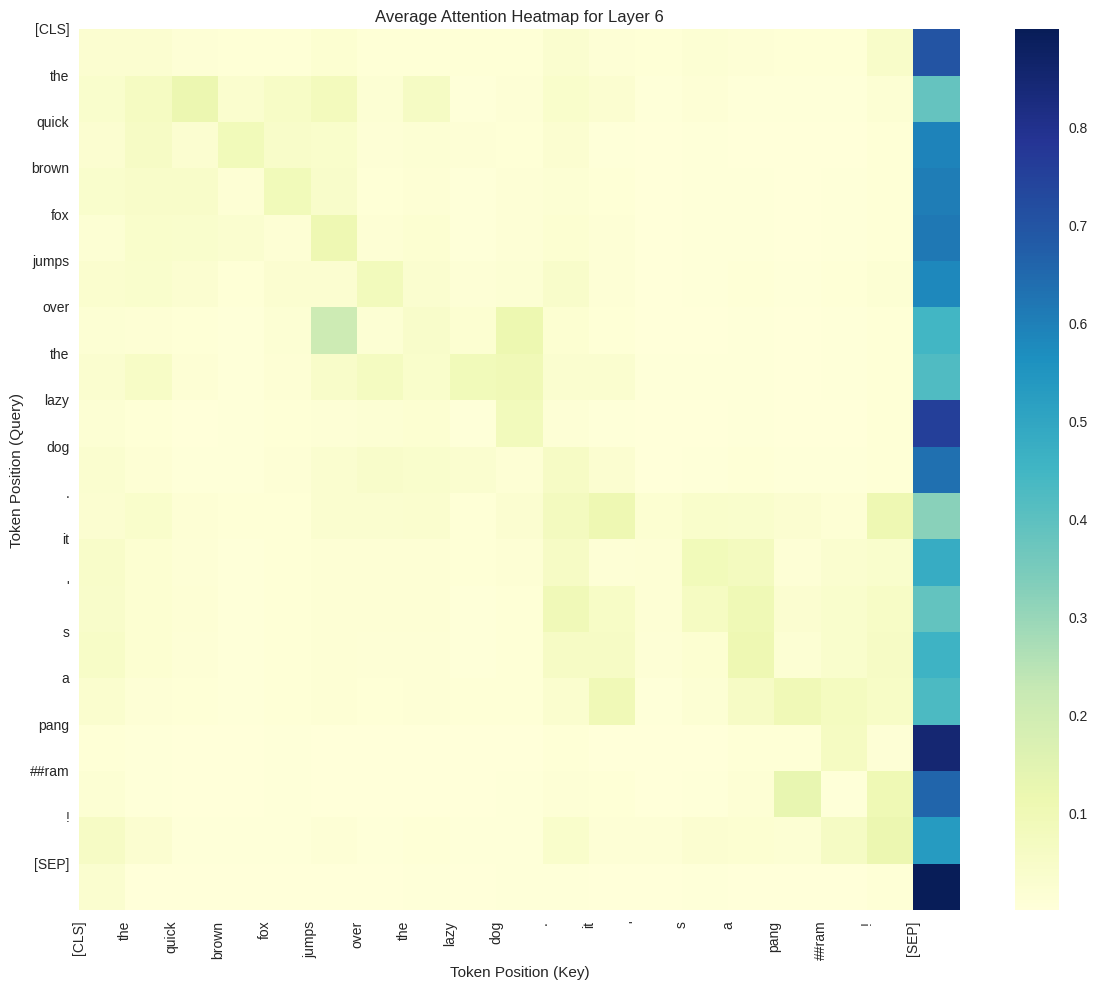

Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', 'it', "'", 's', 'a', 'pang', '##ram', '!', '[SEP]']


In [3]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuração do matplotlib para gráficos mais bonitos
plt.style.use('seaborn')

# Carregar modelo e tokenizador
model = BertModel.from_pretrained('bert-base-uncased', attn_implementation="eager")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_attention_scores(model, input_ids, attention_mask):
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    return outputs.attentions

# Função para calcular scores de especialização
def calculate_specialization_scores(attention_scores):
    num_layers = len(attention_scores)
    num_heads = attention_scores[0].shape[1]

    specialization_scores = np.zeros((num_layers, num_heads, 2))  # 2 for syntactic and semantic

    for layer in range(num_layers):
        layer_attention = attention_scores[layer][0]  # Batch size 1
        for head in range(num_heads):
            head_attention = layer_attention[head]

            # Simplified heuristic:
            # - Diagonal elements represent syntactic attention (local)
            # - Off-diagonal elements represent semantic attention (global)
            syntactic_score = np.diagonal(head_attention).sum()
            semantic_score = head_attention.sum() - syntactic_score

            total = syntactic_score + semantic_score
            specialization_scores[layer, head, 0] = syntactic_score / total
            specialization_scores[layer, head, 1] = semantic_score / total

    return specialization_scores

# Preparar dados e executar inferências
text = "The quick brown fox jumps over the lazy dog. It's a pangram!"
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

attention_scores = get_attention_scores(model, inputs['input_ids'], inputs['attention_mask'])
specialization_scores = calculate_specialization_scores(attention_scores)

# Visualização melhorada
fig, ax = plt.subplots(figsize=(15, 10))

num_layers, num_heads, _ = specialization_scores.shape
x = np.arange(num_layers)
width = 0.35

for head in range(num_heads):
    syntactic_scores = specialization_scores[:, head, 0]
    semantic_scores = specialization_scores[:, head, 1]

    ax.bar(x + (head - num_heads/2 + 0.5) * width / num_heads, syntactic_scores,
           width/num_heads, label=f'Head {head} (Syntactic)', alpha=0.7)
    ax.bar(x + (head - num_heads/2 + 0.5) * width / num_heads, semantic_scores,
           width/num_heads, bottom=syntactic_scores, label=f'Head {head} (Semantic)', alpha=0.7)

ax.set_xlabel('Layer')
ax.set_ylabel('Specialization Score')
ax.set_title('Attention Head Specialization Across Layers')
ax.set_xticks(x)
ax.set_xticklabels(range(1, num_layers + 1))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Visualização adicional: heatmap de atenção para uma camada específica
layer_to_visualize = 5  # Você pode mudar isso para visualizar diferentes camadas
attn_matrix = attention_scores[layer_to_visualize][0].mean(dim=0).numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attn_matrix, annot=False, cmap='YlGnBu')
plt.title(f'Average Attention Heatmap for Layer {layer_to_visualize + 1}')
plt.xlabel('Token Position (Key)')
plt.ylabel('Token Position (Query)')

# Adicionar labels dos tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens, rotation=0)

plt.tight_layout()
plt.show()

print("Tokens:", tokens)

<ipython-input-4-2228e9060b15>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


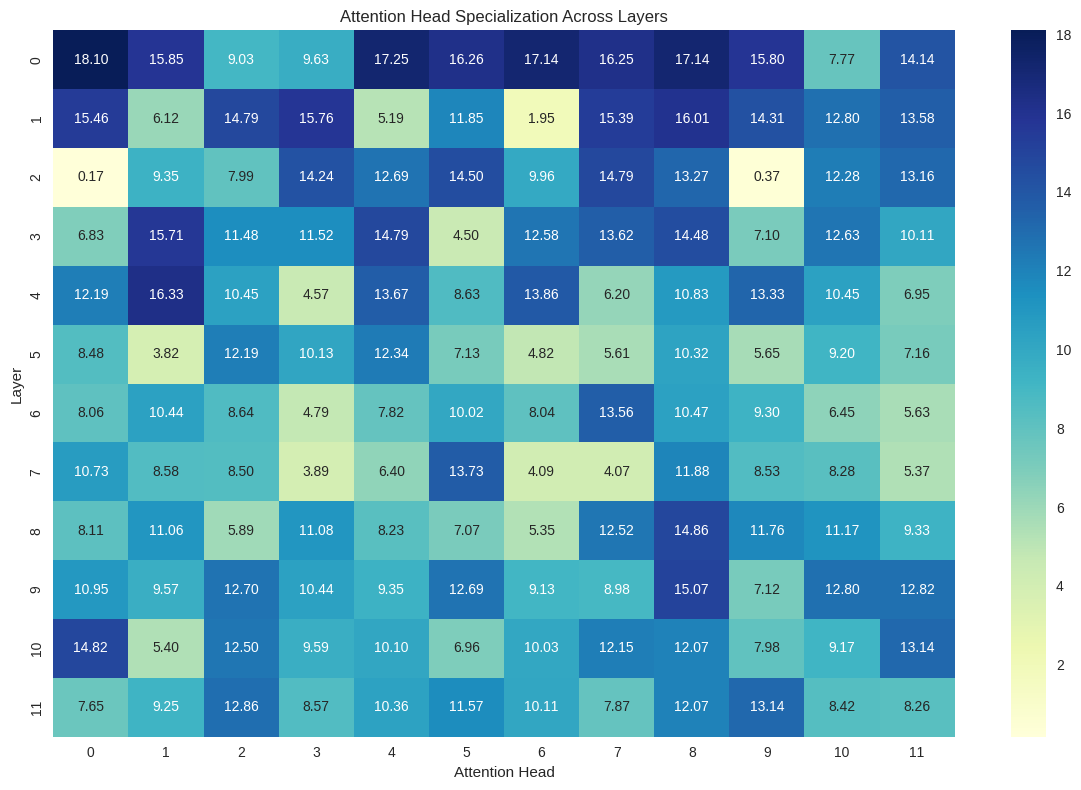

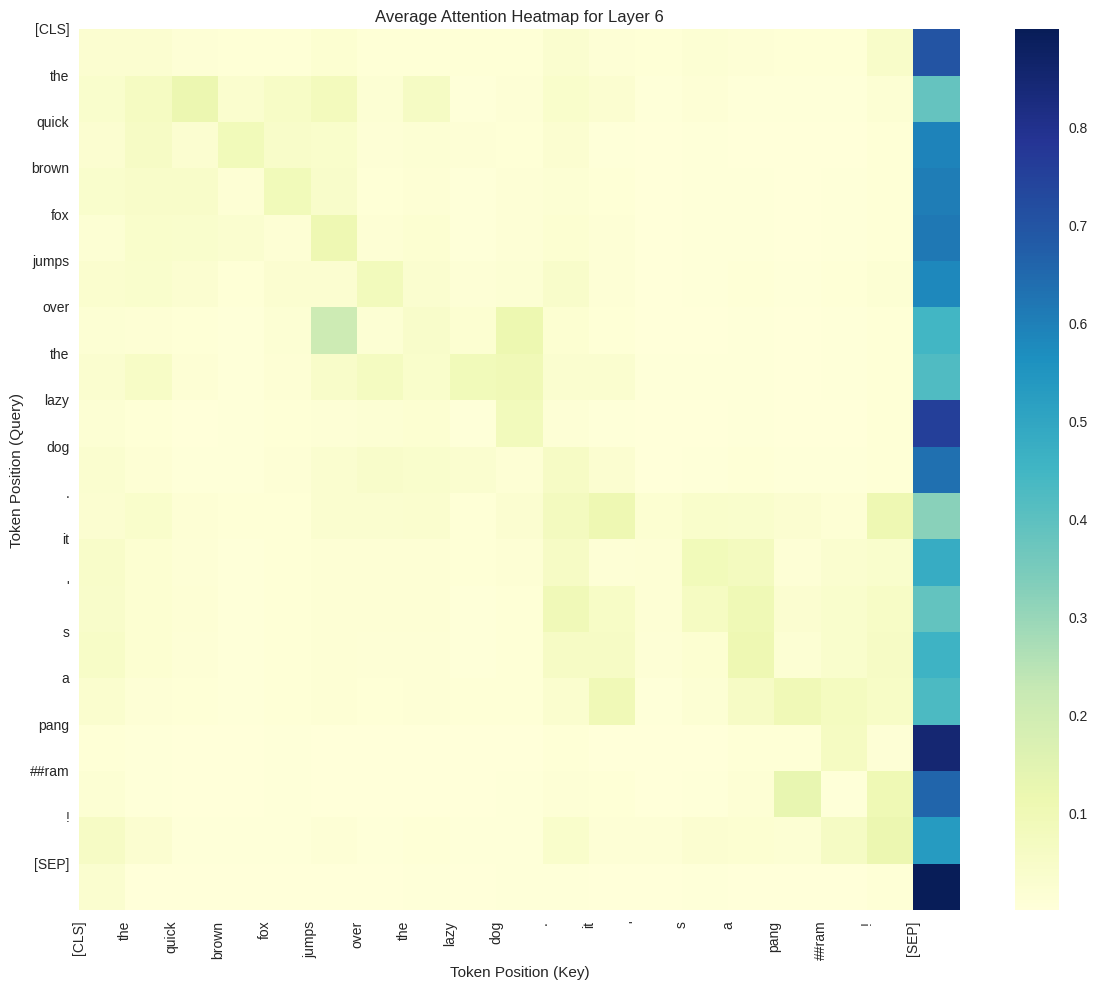

Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', 'it', "'", 's', 'a', 'pang', '##ram', '!', '[SEP]']


In [4]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuração do matplotlib para gráficos mais bonitos
plt.style.use('seaborn')

# Carregar modelo e tokenizador
model = BertModel.from_pretrained('bert-base-uncased', attn_implementation="eager")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_attention_scores(model, input_ids, attention_mask):
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    return outputs.attentions

# Função para calcular scores de especialização
def calculate_specialization_scores(attention_scores):
    num_layers = len(attention_scores)
    num_heads = attention_scores[0].shape[1]

    specialization_scores = np.zeros((num_layers, num_heads))

    for layer in range(num_layers):
        layer_attention = attention_scores[layer][0]  # Batch size 1
        for head in range(num_heads):
            head_attention = layer_attention[head]

            # Calculamos a "globalidade" da atenção
            # Quanto mais uniforme a distribuição, mais "semântica" (global) é a atenção
            entropy = -np.sum(head_attention.numpy() * np.log(head_attention.numpy() + 1e-10))
            max_entropy = np.log(head_attention.shape[0])
            globalness = entropy / max_entropy

            specialization_scores[layer, head] = globalness

    return specialization_scores

# Preparar dados e executar inferências
text = "The quick brown fox jumps over the lazy dog. It's a pangram!"
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

attention_scores = get_attention_scores(model, inputs['input_ids'], inputs['attention_mask'])
specialization_scores = calculate_specialization_scores(attention_scores)

# Visualização simplificada
plt.figure(figsize=(12, 8))
sns.heatmap(specialization_scores, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Attention Head Specialization Across Layers')
plt.xlabel('Attention Head')
plt.ylabel('Layer')
plt.tight_layout()
plt.show()

# Visualização adicional: heatmap de atenção para uma camada específica
layer_to_visualize = 5  # Você pode mudar isso para visualizar diferentes camadas
attn_matrix = attention_scores[layer_to_visualize][0].mean(dim=0).numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attn_matrix, annot=False, cmap='YlGnBu')
plt.title(f'Average Attention Heatmap for Layer {layer_to_visualize + 1}')
plt.xlabel('Token Position (Key)')
plt.ylabel('Token Position (Query)')

# Adicionar labels dos tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens, rotation=0)

plt.tight_layout()
plt.show()

print("Tokens:", tokens)

<ipython-input-5-c271316c908f>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


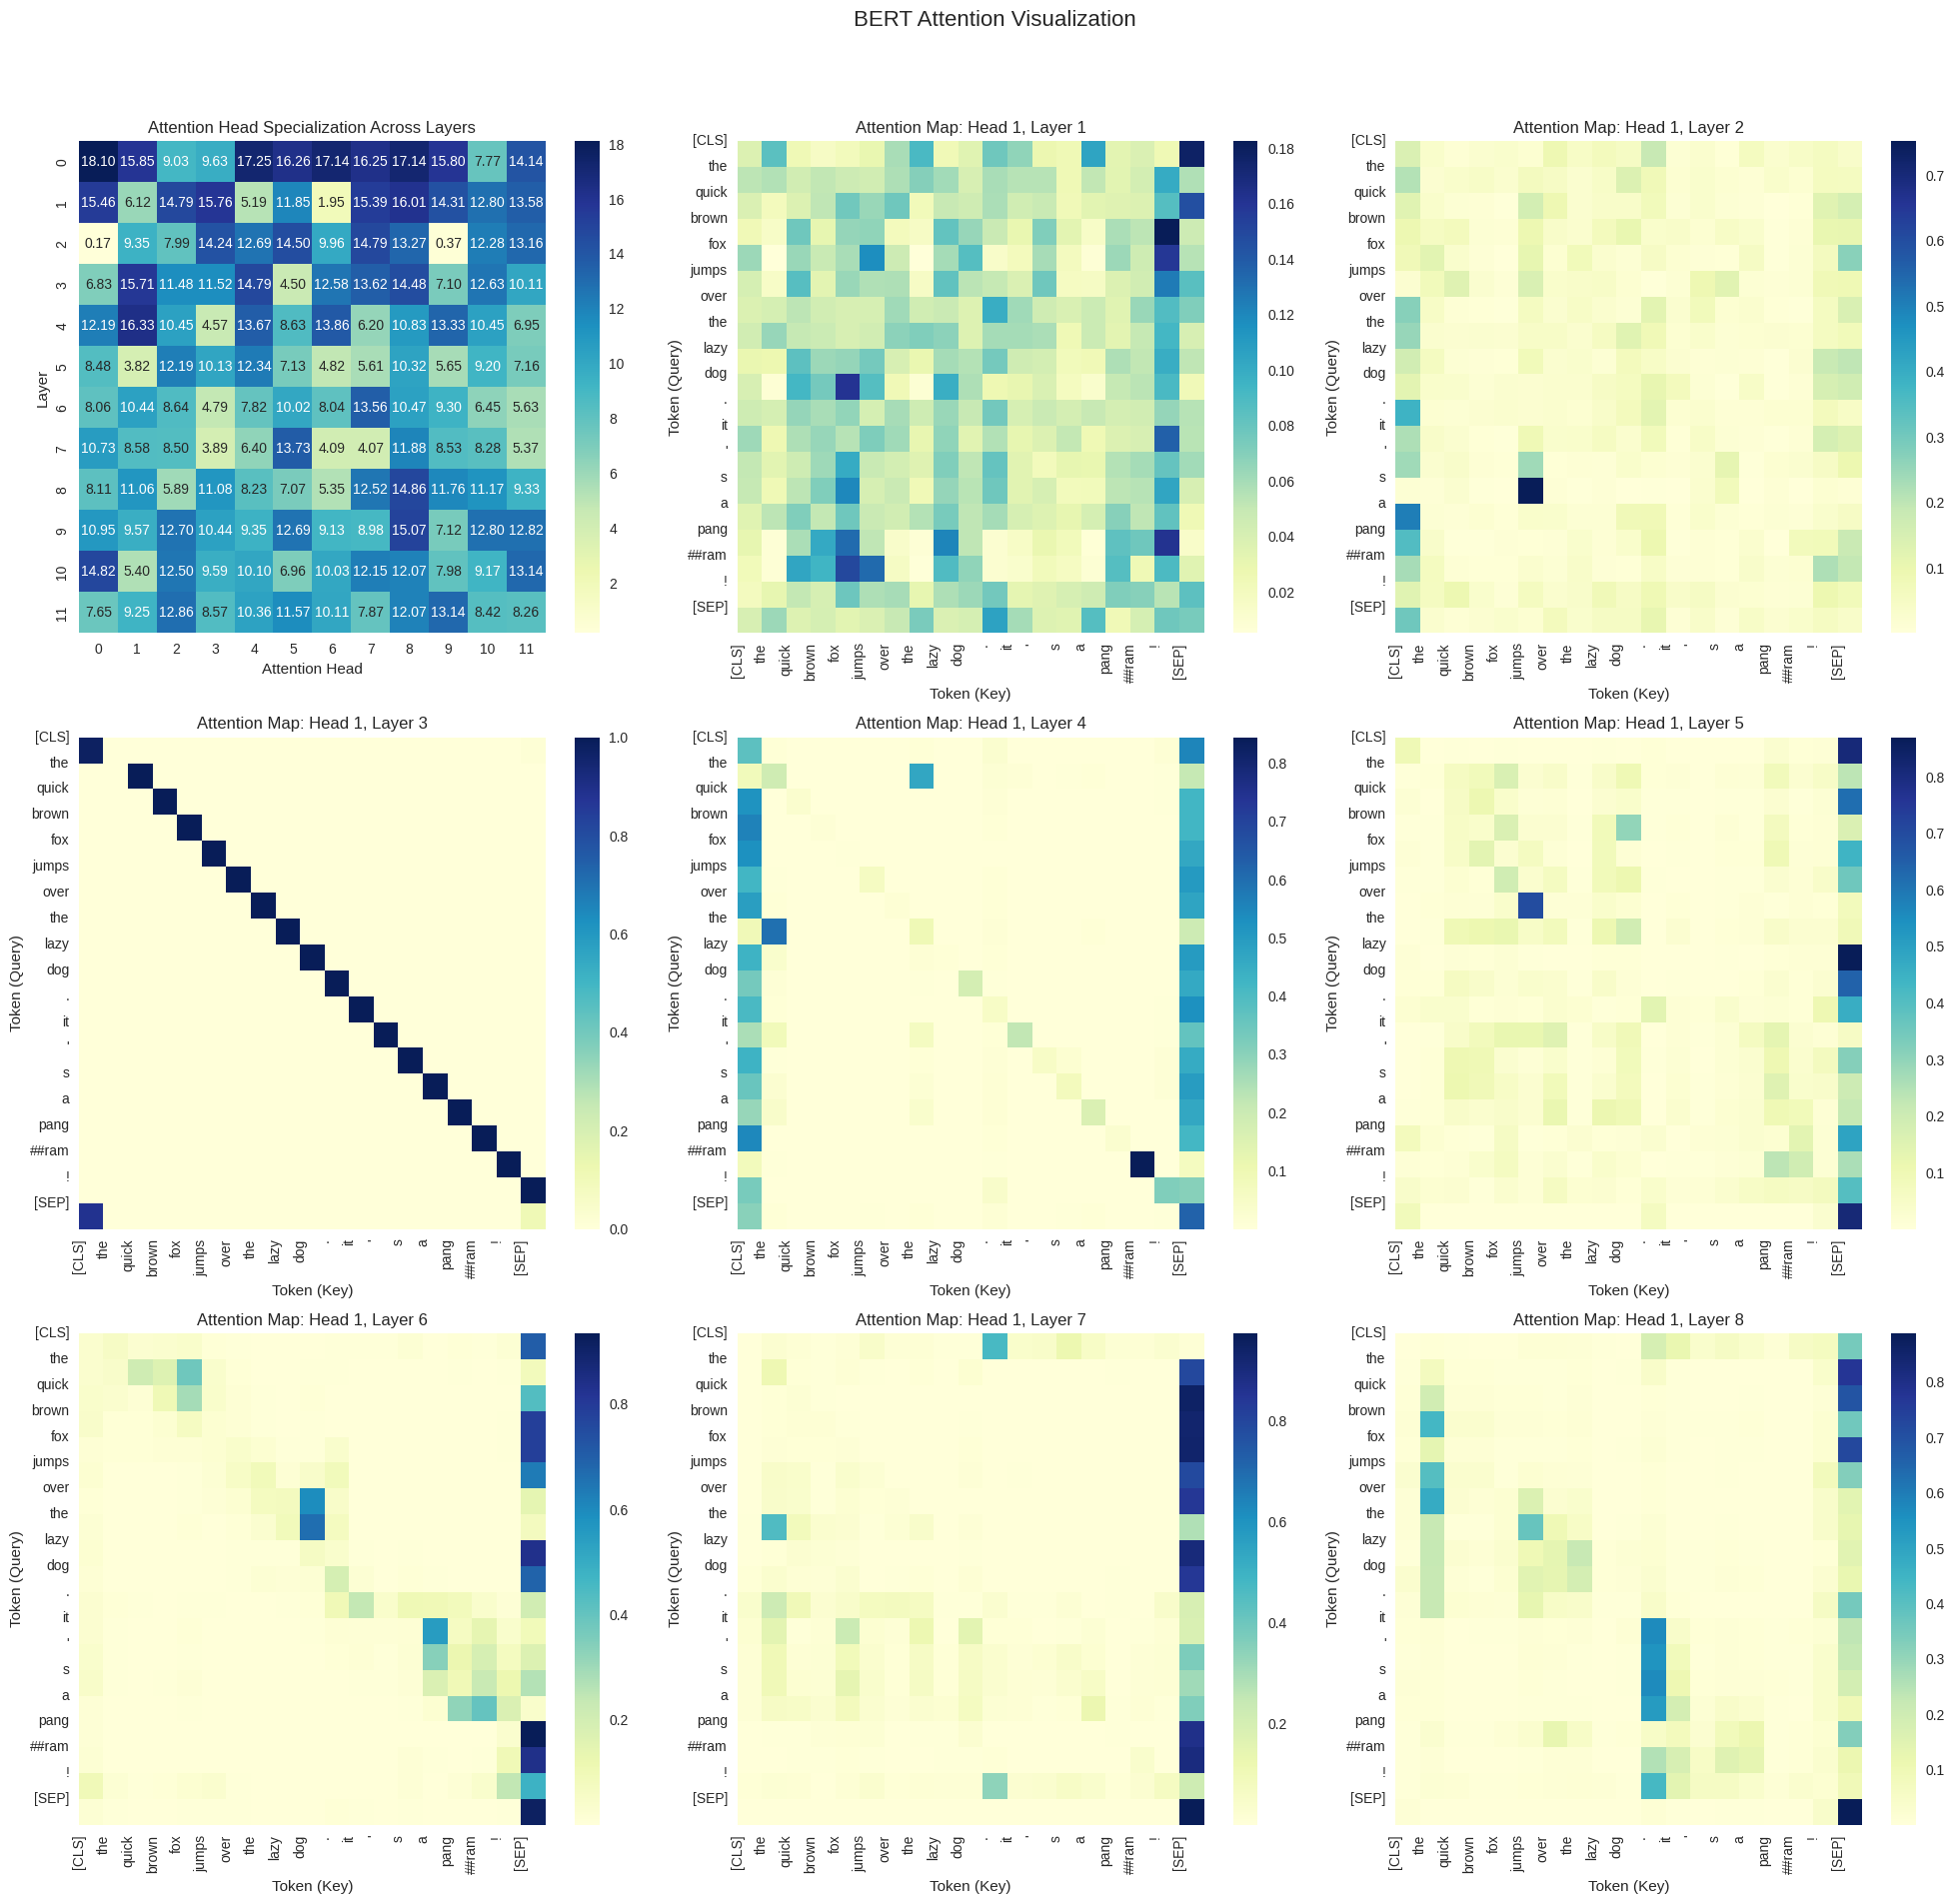

Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', 'it', "'", 's', 'a', 'pang', '##ram', '!', '[SEP]']


In [5]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuração do matplotlib para gráficos mais bonitos
plt.style.use('seaborn')

# Carregar modelo e tokenizador
model = BertModel.from_pretrained('bert-base-uncased', attn_implementation="eager")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_attention_scores(model, input_ids, attention_mask):
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    return outputs.attentions

# Função para calcular scores de especialização
def calculate_specialization_scores(attention_scores):
    num_layers = len(attention_scores)
    num_heads = attention_scores[0].shape[1]

    specialization_scores = np.zeros((num_layers, num_heads))

    for layer in range(num_layers):
        layer_attention = attention_scores[layer][0]  # Batch size 1
        for head in range(num_heads):
            head_attention = layer_attention[head]

            # Calculamos a "globalidade" da atenção
            entropy = -np.sum(head_attention.numpy() * np.log(head_attention.numpy() + 1e-10))
            max_entropy = np.log(head_attention.shape[0])
            globalness = entropy / max_entropy

            specialization_scores[layer, head] = globalness

    return specialization_scores

# Preparar dados e executar inferências
text = "The quick brown fox jumps over the lazy dog. It's a pangram!"
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

attention_scores = get_attention_scores(model, inputs['input_ids'], inputs['attention_mask'])
specialization_scores = calculate_specialization_scores(attention_scores)

# Criar matriz 3x3 de subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('BERT Attention Visualization', fontsize=16)

# Plotar o heatmap geral no primeiro subplot
sns.heatmap(specialization_scores, annot=True, cmap='YlGnBu', fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title('Attention Head Specialization Across Layers')
axs[0, 0].set_xlabel('Attention Head')
axs[0, 0].set_ylabel('Layer')

# Plotar os mapas de atenção para a cabeça 1 em cada camada
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
num_tokens = len(tokens)

for i in range(1, 9):  # 8 camadas restantes na matriz 3x3
    layer = i - 1
    row = i // 3
    col = i % 3

    attn_matrix = attention_scores[layer][0, 0, :num_tokens, :num_tokens].numpy()

    sns.heatmap(attn_matrix, annot=False, cmap='YlGnBu', ax=axs[row, col])
    axs[row, col].set_title(f'Attention Map: Head 1, Layer {layer + 1}')
    axs[row, col].set_xticks(range(num_tokens))
    axs[row, col].set_yticks(range(num_tokens))
    axs[row, col].set_xticklabels(tokens, rotation=90)
    axs[row, col].set_yticklabels(tokens, rotation=0)
    axs[row, col].set_xlabel('Token (Key)')
    axs[row, col].set_ylabel('Token (Query)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Tokens:", tokens)

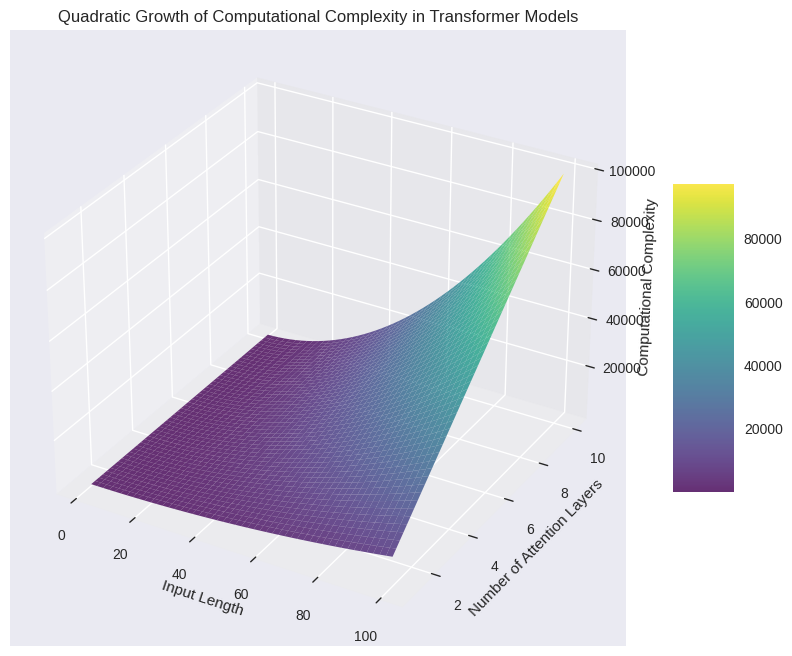

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data
input_length = np.linspace(1, 100, 50)
num_layers = np.linspace(1, 10, 50)
X, Y = np.meshgrid(input_length, num_layers)
Z = X**2 * Y  # Quadratic complexity with respect to input length, linear with respect to layers

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Customize the plot
ax.set_xlabel('Input Length')
ax.set_ylabel('Number of Attention Layers')
ax.set_zlabel('Computational Complexity')
ax.set_title('Quadratic Growth of Computational Complexity in Transformer Models')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()